# Salary Data Classification Models

**Authors:** Franko Ndou

# Overview

The HR department plays a crucial role in identifying the right candidates for job positions. However, the process of determining a candidate's suitability can be time-consuming and subject to biases. To streamline their decision-making process and make it more data-driven, the HR department aims to develop a Machine Learning (ML) classification model. This model will predict whether a candidate is likely to earn more than $50,000 annually, helping the HR team make informed decisions about candidate qualifications.

# Dataset

I got my dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). It is salary cenus data from 1994, The target varible within the dataset is "income" which tells us if an individual makes Above $50,000 a year (1), or if they make less than or equal to that number (0).

# Importing packages and intializing data

We want to make sure that we have all the tools required. We will be using a class that we created for our own tailored hyperparameter tuning

In [2]:
#Import necessary packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.io import arff
import warnings


warnings.filterwarnings('ignore')

In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import ParameterGrid
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Defining the class
class ModelValidator:
    # Creating attributes that define and use later
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cv_results = None
        self.cv_mean = None
        self.cv_top_lr = None
        self.cv_top_dt = None
        self.top_hp_lr = None
        self.top_3_lr = None
        self.top_hp_dt = None
        self.top_3_dt = None
        self.top_model_lr = None
        self.top_model_dt = None

    # Defining the cross-validation method
    def cross_validate(self, model, kfolds=10):
        self.cv_results = cross_val_score(model, self.X_train, self.y_train, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        return self.cv_mean
    
    # Checking for multicollinearity
    def check_multicollinearity(self):
        X_train = self.X_train  # Get your training data
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
        vif["features"] = X_train.columns
        vif_sorted = vif.sort_values('VIF Factor', ascending=False)
        return vif_sorted
    
    #Down Sampler
    @staticmethod
    def downsample(X_train, y_train, target_column, random_state=42):
        
        # Separate majority and minority classes
        majority_class = X_train[X_train[target_column] == 0]
        minority_class = X_train[X_train[target_column] == 1]

        # Downsample majority class
        majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=random_state)

        # Combine minority class with downsampled majority class
        downsampled_data = pd.concat([majority_downsampled, minority_class])
    
        # Separate features and target in the downsampled data
        X_downsampled = downsampled_data.drop(target_column, axis=1)
        y_downsampled = downsampled_data[target_column]

        return X_downsampled, y_downsampled

    
    # Defining precision improving method
    def check_precision(self, cv_now=False):
        # Create a dictionary with ranges on the hyperparameters relevant to precision tuning
        precision_hyperp = {
            'C': [0.001, 0.01, 0.1, 1.0, 10],  # Adjusted range with smaller values
            'penalty': ['l2'],  # Use 'l2' penalty for smoother decision boundaries
            'solver': ['lbfgs', 'liblinear', 'newton-cg'],  # Common solvers for 'l2' penalty
            'tol': [1e-5, 1e-4, 1e-3],
            'random_state': [42],  # Set random state to 42 for reproducibility
            'max_iter': [1000, 10000]
        }

        top_3_precision = []

        # Instantiate the model (e.g., LogisticRegression or DecisionTreeClassifier) with a random state
        model_inst = LogisticRegression(random_state=42)  

        # Loop through hyperparameter combinations
        for params in ParameterGrid(precision_hyperp):
            try:
                model_inst.set_params(**params)
                model_inst.fit(self.X_train, self.y_train)
                y_pred = model_inst.predict(self.X_test)
                precision = precision_score(self.y_test, y_pred)  # Calculate precision score

                if cv_now:
                    cv_precision = self.cross_validate(model_inst)  # Optionally, calculate cross-validation precision
                    top_3_precision.append((params, cv_precision, precision))
                else:
                    top_3_precision.append((params, precision))

            except ValueError as e:
                continue

        top_3_precision.sort(key=lambda x: x[-1], reverse=True)
        top_hp_precision = top_3_precision[:1]

        # Save the best hyperparameters and the tuned model
        self.top_3_precision = top_3_precision
        self.top_hp_precision = top_hp_precision
        self.top_model_precision = LogisticRegression(random_state=42).set_params(**top_hp_precision[0][0]).fit(self.X_train, self.y_train)

        
          #Defining my logistic regression improving method.
    
    def check_log_reg(self, cv_now=False):
        #Create a dictionary with ranges on the hyperparameters
        log_reg_hyperp = {
            'C': [0.01,0.1, 1.0,10,100,1000],
            'penalty': ['l1', 'l2','elasticnet'],
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
            'tol': [1e-5,1e-4, 1e-3],
            'random_state': [42],
            'max_iter':[1000,10000]
    }
        
        top_3_lr = []

        #Instantiating the model and looping through the different combinations of hyperparameters for a logistic regression model.
        
        model_inst = LogisticRegression()
        for params in ParameterGrid(log_reg_hyperp):
            try:
                model_inst.set_params(**params)
                model_inst.fit(self.X_train, self.y_train)
                y_pred = model_inst.predict(self.X_test)
                test_accuracy = accuracy_score(self.y_test, y_pred)
                if cv_now:
                    cv_accuracy = self.cross_validate(model_inst)
                    top_3_lr.append((params, cv_accuracy, test_accuracy))
                else:
                    top_3_lr.append((params, test_accuracy))
                
            except ValueError as e:
                continue

        top_3_lr.sort(key=lambda x: x[-1], reverse=True)
        top_hp_lr = top_3_lr[:1]
        top_3_lr = top_3_lr[:3]
        
        # Saving the attributes
        
        self.top_3_lr = top_3_lr
        self.top_hp_lr = top_hp_lr
        self.top_model_lr = LogisticRegression().set_params(**self.top_hp_lr[0][0]).fit(self.X_train,self.y_train)

        
    # Defining a model method to loop and find the best combination of hyperparameters for my decision tree
    def check_desc_tree(self, cv_now=False):
        # Creating a dictionary with the hyperparameters combinations
        decision_tree_hyperp = {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': range(1, 8),
            'min_samples_split': range(2, 4),
            'min_samples_leaf': range(1, 4),
            'random_state': [42],  # Set random state to 42
        }

        top_3_dt = []

        # Instantiating the model, looping through them and finding top performers
        model_inst = DecisionTreeClassifier(random_state=42)  # Set random state to 42
        for params in ParameterGrid(decision_tree_hyperp):
            try:
                model_inst.set_params(**params)
                model_inst.fit(self.X_train, self.y_train)
                y_pred = model_inst.predict(self.X_test)
                test_accuracy = accuracy_score(self.y_test, y_pred)
                if cv_now:
                    cv_accuracy = self.cross_validate(model_inst)
                    top_3_dt.append((params, cv_accuracy, test_accuracy))
                else:
                    top_3_dt.append((params, test_accuracy))
            except ValueError as e:
                continue

        top_3_dt.sort(key=lambda x: x[-1], reverse=True)
        top_hp_dt = top_3_dt[:1]
        top_3_dt = top_3_dt[:3]

        # Saving attributes
        self.top_3_dt = top_3_dt
        self.top_hp_dt = top_hp_dt
        self.top_model_dt = DecisionTreeClassifier(random_state=42).set_params(**self.top_hp_dt[0][0]).fit(self.X_train,
                                                                                                           self.y_train)

    # Plotting Confusion Matrix for top-performing models
    def plot_confusion_matrix(self):
        # Train the best Logistic Regression model
        lr_model = LogisticRegression(random_state=42).set_params(**self.top_hp_lr[0][0])
        lr_model.fit(self.X_train, self.y_train)

        # Train the best Decision Tree model
        dt_model = DecisionTreeClassifier(random_state=42).set_params(**self.top_hp_dt[0][0])
        dt_model.fit(self.X_train, self.y_train)

        # Generate confusion matrices for Logistic Regression and Decision Tree
        lr_cm = confusion_matrix(self.y_test, lr_model.predict(self.X_test))
        dt_cm = confusion_matrix(self.y_test, dt_model.predict(self.X_test))

        # Display confusion matrix for Logistic Regression
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        disp_lr = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=['Class 0', 'Class 1'])
        disp_lr.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title("Confusion Matrix for Logistic Regression")

        # Display confusion matrix for Decision Tree
        plt.subplot(1, 2, 2)
        disp_dt = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=['Class 0', 'Class 1'])
        disp_dt.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title("Confusion Matrix for Decision Tree")
        
        plt.tight_layout()
        plt.show()


    # Plotting ROC Curve for top-performing models
    def plot_roc_curve(self):
        top_model_lr = LogisticRegression(random_state=42).set_params(**self.top_hp_lr[0][0]).fit(self.X_train, self.y_train)
        top_model_dt = DecisionTreeClassifier(random_state=42).set_params(**self.top_hp_dt[0][0]).fit(self.X_train, self.y_train)

        fpr_lr, tpr_lr, _ = roc_curve(self.y_test, top_model_lr.predict_proba(self.X_test)[:, 1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)

        fpr_dt, tpr_dt, _ = roc_curve(self.y_test, top_model_dt.predict_proba(self.X_test)[:, 1])
        roc_auc_dt = auc(fpr_dt, tpr_dt)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression ROC curve (area = {:.2f})'.format(roc_auc_lr))
        plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label='Decision Tree ROC curve (area = {:.2f})'.format(roc_auc_dt))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()


    # Determining most important features for my data
    def feature_importance(self, n=10):
        if self.top_hp_lr[0][-1] < self.top_hp_dt[0][-1]:
            top_model = DecisionTreeClassifier(random_state=42).set_params(**self.top_hp_dt[0][0])
        else:
            top_model = LogisticRegression(random_state=42).set_params(**self.top_hp_lr[0][0])

        if isinstance(self.X_train, np.ndarray):
            # Convert X_train to a DataFrame if it's a NumPy array
            features_used = pd.DataFrame(self.X_train, columns=self.X_train.columns)
        else:
            features_used = self.X_train

        top_model.fit(features_used, self.y_train)
    
        if isinstance(self.X_train, np.ndarray):
            feature_importance = list(zip(top_model.feature_importances_, features_used.columns))
        else:
            feature_importance = list(zip(abs(top_model.coef_[0]), features_used.columns))
    
        feature_importance.sort(key=lambda x: x[0], reverse=True)
        return feature_importance[:n]


    
    # Creating a method to obtain the score DataFrame
    def scores(self, both_models=False, include_precision=True):
        dt_y_hat_train = self.top_model_dt.predict(self.X_train)
        dt_y_hat_test = self.top_model_dt.predict(self.X_test)
        lr_y_hat_train = self.top_model_lr.predict(self.X_train)
        lr_y_hat_test = self.top_model_lr.predict(self.X_test)
        self.cv_top_lr = self.top_hp_lr[0][1]
        self.cv_top_dt = self.top_hp_dt[0][1]

        dt_metrics = {
            'Accuracy train': round(accuracy_score(self.y_train, dt_y_hat_train), 3),
            'Accuracy test': round(accuracy_score(self.y_test, dt_y_hat_test), 3),
            'Recall train': round(recall_score(self.y_train, dt_y_hat_train), 3),
            'Recall test': round(recall_score(self.y_test, dt_y_hat_test), 3),
            'F1 train': round(f1_score(self.y_train, dt_y_hat_train), 3),
            'F1 test': round(f1_score(self.y_test, dt_y_hat_test), 3),
            'CV results': round(self.cv_top_dt, 3)
        }

        lr_metrics = {
            'Accuracy train': round(accuracy_score(self.y_train, lr_y_hat_train), 3),
            'Accuracy test': round(accuracy_score(self.y_test, lr_y_hat_test), 3),
            'Recall train': round(recall_score(self.y_train, lr_y_hat_train), 3),
            'Recall test': round(recall_score(self.y_test, lr_y_hat_test), 3),
            'F1 train': round(f1_score(self.y_train, lr_y_hat_train), 3),
            'F1 test': round(f1_score(self.y_test, lr_y_hat_test), 3),
            'CV results': round(self.cv_top_lr, 3)
        }

        if include_precision:
            precision_metrics = {
                'Precision train': round(precision_score(self.y_train, self.top_model_precision.predict(self.X_train)), 3),
                'Precision test': round(precision_score(self.y_test, self.top_model_precision.predict(self.X_test)), 3)
            }
            dt_metrics.update(precision_metrics)
            lr_metrics.update(precision_metrics)

        decision_tree_df = pd.DataFrame(list(dt_metrics.values()), index=dt_metrics.keys(), columns=['Decision Tree'])
        logistic_regression_df = pd.DataFrame(list(lr_metrics.values()), index=lr_metrics.keys(),
                                               columns=['Logistic Regression'])

        if both_models:
            df = pd.concat([decision_tree_df, logistic_regression_df], axis=1)
            return df
        else:
            if self.top_hp_lr[0][-1] < self.top_hp_dt[0][-1]:
                return decision_tree_df
            else:
                return logistic_regression_df


    # Creating a method to plot the decision tree
    def plot_tree(self):
        f, ax = plt.subplots(figsize=(8, 8))
        plot_tree(self.top_model_dt, ax=ax)
        plt.title('Decision Tree Classifier')

In [4]:
# Initializing DataFrame
df = pd.read_csv("../data/SalaryData.csv")
df

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,0
1,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,0
2,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,0
3,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,1,0,0,40,0
4,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...
27498,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,1,0,0,38,0
27499,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,0,0,0,40,1
27500,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,1,0,0,40,0
27501,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,0,0,0,20,0


In [5]:
# Checking column data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27503 entries, 0 to 27502
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27503 non-null  int64 
 1   workclass       27503 non-null  object
 2   education       27503 non-null  object
 3   marital-status  27503 non-null  object
 4   occupation      27503 non-null  object
 5   relationship    27503 non-null  object
 6   race            27503 non-null  object
 7   sex             27503 non-null  int64 
 8   capital-gain    27503 non-null  int64 
 9   capital-loss    27503 non-null  int64 
 10  hours-per-week  27503 non-null  int64 
 11  income          27503 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ MB


# Spliting the dataset

To be able to create models and predictions with our data we need to split it into a train and test dataset. This will allow us to have a dataset that we can train and tune then test it on unseen data

In [6]:
# Creating test split
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing 

We usually perform these next steps after splitting to prevent data leakage, it also allows us to begin hyper paramater tuning our model so that it can fit generalized data sets

In [7]:
# Define numerical and categorical columns
numerical_columns = ['age', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race']

# Define a custom order for the 'education' column
custom_order = [
    ' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th',
    ' 10th', ' 11th', ' 12th', ' HS-grad', ' Some-college',
    ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Masters',
    ' Prof-school', ' Doctorate'
]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numerical columns
        ('cat', Pipeline([
            ('ord', OrdinalEncoder(categories=[custom_order])),  # Encode 'education' column with custom order
            ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore', categories='auto'))
        ]), ['education']),  # Encode 'education' column with custom order
        ('cat_oh', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), categorical_columns)  # Encode other categorical columns
    ])

# Fit the preprocessing step on the training data
preprocessor.fit(X_train)

# Transform the training and test data using the preprocessing step
X_train_pp = preprocessor.transform(X_train)
X_test_pp = preprocessor.transform(X_test)

# Define my pipeline with preprocessing and the Logistic Regression model
pipeline = Pipeline([
    ('model', LogisticRegression())
])

# Fit the pipeline on the preprocessed training data
pipeline.fit(X_train_pp, y_train)

# Make predictions on the preprocessed test data
y_pred = pipeline.predict(X_test_pp)

After encoding all the columns properly, making sure to use ordinal encoder for the education column as the order is likely significant to the models predictive cabailities. We can begin to balance and then predict with our dataset

# Balancing the dataset - SMOTE

Our dataset is incredibly imbalanced, so were going to need to oversample it and add synthetic data so that we can remove any bias

In [8]:
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_pp, y_train)

# Train the machine learning model on the balanced training data (e.g., Logistic Regression)
model = LogisticRegression()
model.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression()

In [9]:
y_train.value_counts(normalize = True)

0    0.745377
1    0.254623
Name: income, dtype: float64

In [10]:
y_train_SMOTE.value_counts(normalize = True)

1    0.5
0    0.5
Name: income, dtype: float64

We've added synthetic data to fix the balance of the dataset so that we can reliably trust our evaluation metrics. Now we can begin to actually predict with our model and hyper-parameter tune.

# Bassline Logistic Regression - SMOTE

The defintion of a "good" model varries completely. Based on the metrics we chose and the baseline model. We are going to be relying on accuracy and precision as our metrics of evaluation, as we want to reduce as many false positives as possible. If someone makes over $50k a year, they likely wont take the offer. So to save HR time and resources, we want to make sure that we dont turn anyone down who may actually accept the offer.

In [11]:
baseline_model = LogisticRegression(random_state=42)
basel_mod_reg = baseline_model.fit(X_train_SMOTE, y_train_SMOTE)
y_hat_train = baseline_model.predict(X_train_SMOTE)
y_hat_test = baseline_model.predict(X_test_pp)

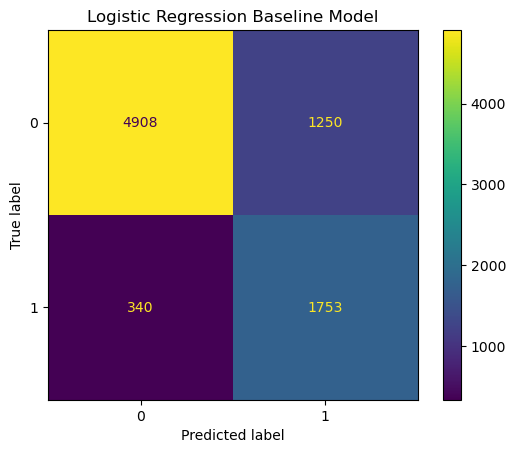

In [14]:
ConfusionMatrixDisplay.from_estimator(basel_mod_reg, X_test_pp, y_test)
plt.title('Logistic Regression Baseline Model');

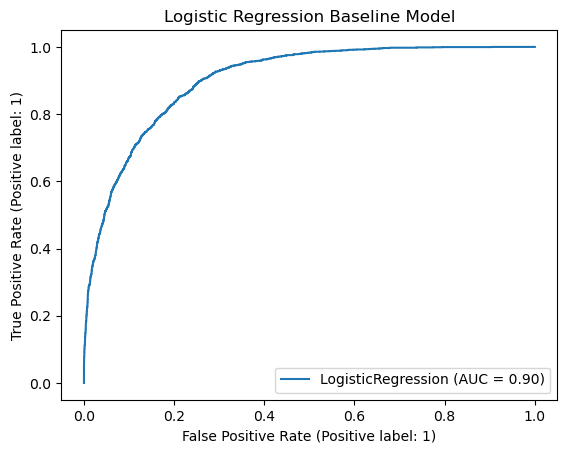

In [15]:
RocCurveDisplay.from_estimator(basel_mod_reg, X_test_pp, y_test)
plt.title("Logistic Regression Baseline Model");

In [16]:
# Results of our tests
print(F"""
Results for the Logistic Regression Baseline Model:

Accuracy train Data: {round(accuracy_score(y_train_SMOTE, y_hat_train) * 100, 2)}%
Accuracy test Data: {round(accuracy_score(y_test, y_hat_test) * 100, 2)}%

Recall train Data: {round(recall_score(y_train_SMOTE, y_hat_train) * 100, 2)}%
Recall test Data: {round(recall_score(y_test, y_hat_test) * 100, 2)}%

Precision train Data: {round(precision_score(y_train_SMOTE, y_hat_train) * 100, 2)}%
Precision test Data: {round(precision_score(y_test, y_hat_test) * 100, 2)}%

F1 train Data: {round(f1_score(y_train_SMOTE, y_hat_train) * 100, 2)}%
F1 test Data: {round(f1_score(y_test, y_hat_test) * 100, 2)}%
""")


Results for the Logistic Regression Baseline Model:

Accuracy train Data: 82.8%
Accuracy test Data: 80.73%

Recall train Data: 85.96%
Recall test Data: 83.76%

Precision train Data: 80.86%
Precision test Data: 58.37%

F1 train Data: 83.33%
F1 test Data: 68.8%



Our accurarcy is pretty good, its not extremely far off the train dataset however it can definitely be improved. Our goal is to raise the accuracy above the baseline model through hyper-parameter tuning 

Our precision is very bad though. Clearly some fitting needs to be done and our model is susceptible to false positives

The AUC curve is already good so if we can raise it even more that would be great

# Baseline Decision Tree - SMOTE

Decision Trees are extremely susceptible to overfitting, so we know for sure were going to have to tune this quite a bit and make sure that our model can actually be generalized. Its likely the model will go "too deep" and cause issues for our test set.

In [17]:
# Instantiating the decision tree
tree_baseline = DecisionTreeClassifier(random_state=42)
#Fitting and getting scores for both train and test
tree_baseline.fit(X_train_SMOTE, y_train_SMOTE)
dt_train_score = tree_baseline.score(X_train_SMOTE, y_train_SMOTE)
dt_test_score = tree_baseline.score(X_test_pp, y_test)
y_hat_dt_train = tree_baseline.predict(X_train_SMOTE)
y_hat_dt_test  = tree_baseline.predict(X_test_pp)

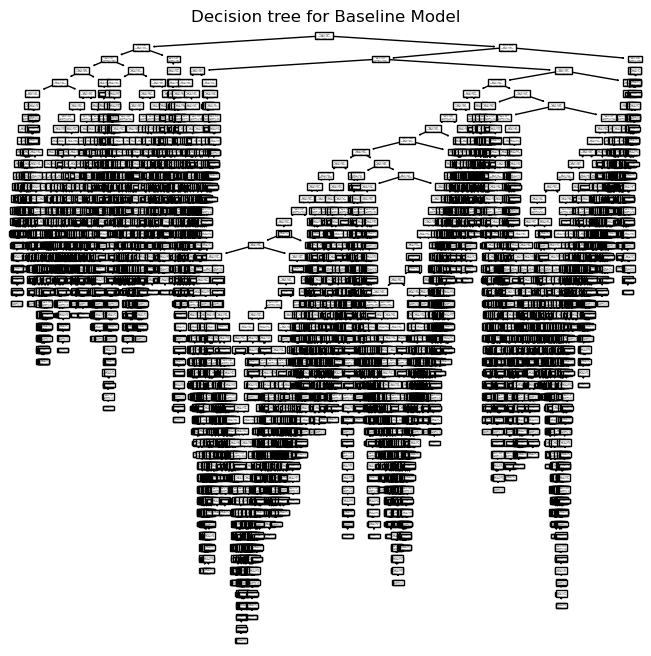

In [18]:
f, ax = plt.subplots(figsize=(8, 8))
plot_tree(tree_baseline, ax=ax)
plt.title('Decision tree for Baseline Model');

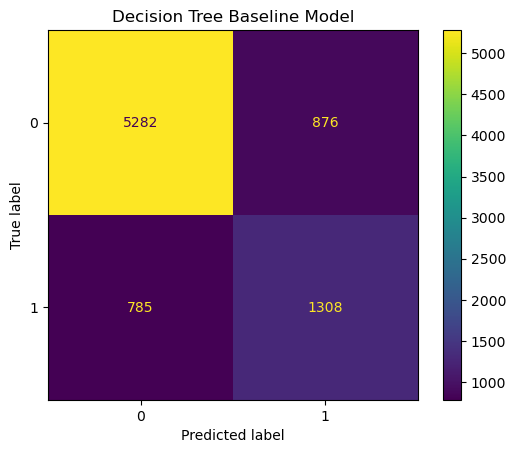

In [19]:
ConfusionMatrixDisplay.from_estimator(tree_baseline.fit(X_train_SMOTE, y_train_SMOTE), X_test_pp, y_test)
plt.title('Decision Tree Baseline Model');

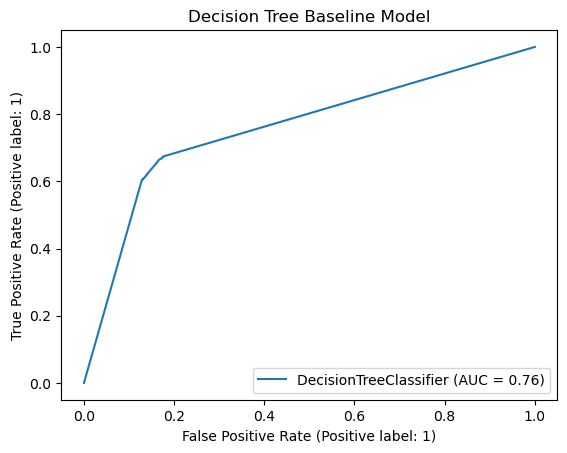

In [20]:
RocCurveDisplay.from_estimator(tree_baseline.fit(X_train_SMOTE, y_train_SMOTE), X_test_pp, y_test)
plt.title("Decision Tree Baseline Model");

In [21]:
print(F"""
Results for the Decision Tree Baseline Model:

Accuracy train Data: {round(accuracy_score(y_train_SMOTE, y_hat_dt_train) * 100, 2)}%
Accuracy test Data: {round(accuracy_score(y_test, y_hat_dt_test) * 100, 2)}%

Recall train Data: {round(recall_score(y_train_SMOTE, y_hat_dt_train) * 100, 2)}%
Recall test Data: {round(recall_score(y_test, y_hat_dt_test) * 100, 2)}%

Precision train Data: {round(precision_score(y_train_SMOTE, y_hat_dt_train) * 100, 2)}%
Precision test Data: {round(precision_score(y_test, y_hat_dt_test) * 100, 2)}%

F1 train Data: {round(f1_score(y_train_SMOTE, y_hat_dt_train) * 100, 2)}%
F1 test Data: {round(f1_score(y_test, y_hat_dt_test) * 100, 2)}%
""")



Results for the Decision Tree Baseline Model:

Accuracy train Data: 98.38%
Accuracy test Data: 79.87%

Recall train Data: 97.69%
Recall test Data: 62.49%

Precision train Data: 99.05%
Precision test Data: 59.89%

F1 train Data: 98.37%
F1 test Data: 61.16%



As expected the decision tree model is performing much worse compared to the logisitc regression out of the box. However this is to be expected and shouldnt alarm us. These scores clearly show us that the model is extremely overfitted and needs to be toned down. However its possible after all regulations, tuning, and cross-validations, the model will outperform logistic regressions. We have to experiment

# Finding the best performing model - SMOTE

In [22]:
#Instantiating our ModelValidator class
validator = ModelValidator(X_train_SMOTE, y_train_SMOTE,X_test_pp,y_test)

#Calling the decision tree and logistic regression checking functions including the cross validation.

validator.check_desc_tree(cv_now=True)
validator.check_log_reg(cv_now=True)
validator.check_precision(cv_now=True)

In [23]:
# Observing the best hyperparameters for logistic regression

validator.top_hp_lr

[({'C': 1.0,
   'max_iter': 1000,
   'penalty': 'l1',
   'random_state': 42,
   'solver': 'liblinear',
   'tol': 1e-05},
  0.8272125435540069,
  0.8072960853229911)]

In [24]:
#Observing the best hyperparameters for decision trees

validator.top_hp_dt

[({'criterion': 'gini',
   'max_depth': 7,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'random_state': 42},
  0.8280139372822302,
  0.7765119379469155)]

In [25]:
#Observing the best hyperparameters for precision
validator.top_hp_precision

[({'C': 10,
   'max_iter': 1000,
   'penalty': 'l2',
   'random_state': 42,
   'solver': 'liblinear',
   'tol': 0.001},
  0.827560975609756,
  0.5838053982005998)]

In [26]:
#Looking at different scores,
validator.scores(both_models=True)

,Decision Tree,Logistic Regression
Accuracy train,0.833,0.828
Accuracy test,0.777,0.807
Recall train,0.911,0.860
Recall test,0.852,0.838
F1 train,0.845,0.833
F1 test,0.659,0.688
CV results,0.828,0.827
Precision train,0.809,0.809
Precision test,0.584,0.584


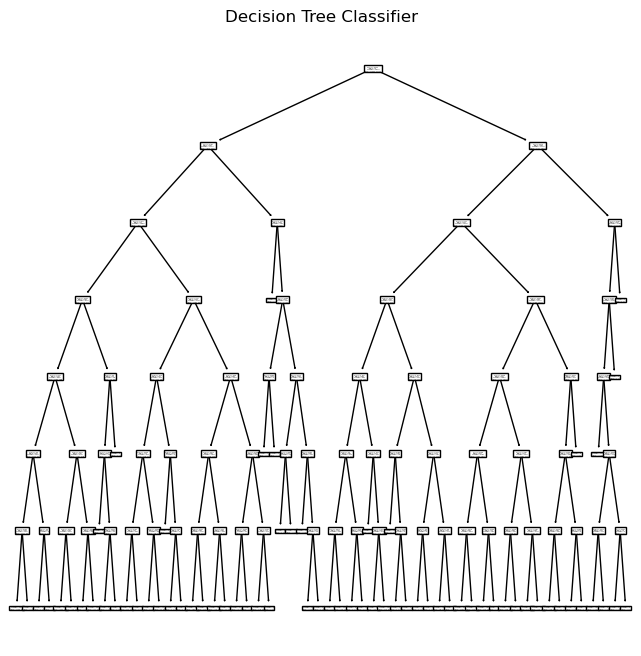

In [27]:
#Plotting decision tree
validator.plot_tree()

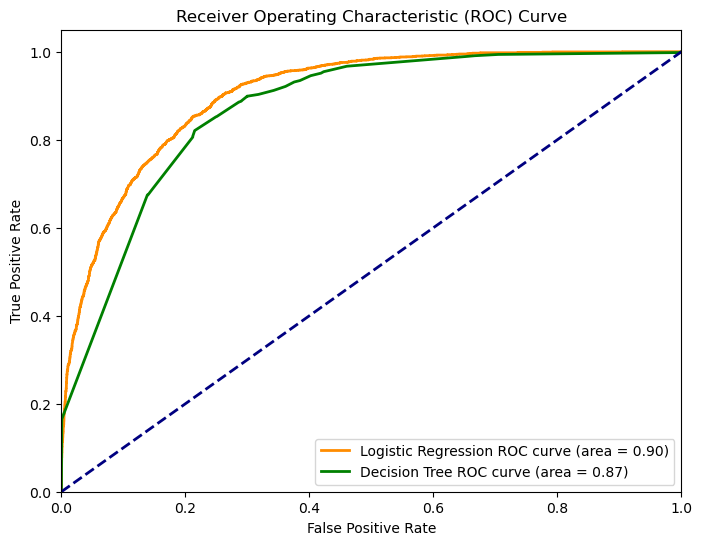

In [28]:
# Plotting ROC Curve
validator.plot_roc_curve()

# Results

It seems like our logistic regression model hasnt improved much accuracy or precision wise, We have created functions to test a multitude of hyperparameter tuning which leaves me to the conclusion that we may need to use a different model to improve our scores even further. As for the Decision tree its is very clear that there is a large improvement.

Both Models have a great AUC with .90 LR and .88 DT respectively. We also managed to really cut down on the depth of the DT and make it much more efficent and much less over fitted.

Clearly weve brought down the Decision Tree depth quite a bit and made the model much more effective at generalizing its predictions. Theres been a clear improvement with the Decision Tree and not much with the Logistic regression. Out of the two models I would still use the LR model simply because of the better testing scores and AUC curve.

However I dont think these models work best with this dataset given our pre-processing steps and hyperparameter tuning. It might be better to utilize a different form of classification model.

# Recomendations

- Use the logistic regression model over the decision tree model. The accuracy score is much better as well as the ROC.

- Could use both as a method to verify the strength of a canidate

# Next Steps

- Upload ML model to a cloud service (AWS, Saturn Cloud, ETC) to effectively try more hyperparameter tuning

- Utilize other forms of classification models to try and achieve better scores (KNN, Random Forest, Etc)

- Polish up our ModelValidator Class and PipeLines to streamline our model training and testing to allow for more versatility and efficientcy